# Tecnologías Serverless


![Serverless](https://www.silversands.co.uk/wp-content/uploads/Serverless-Computing.png)


Esta hoja muestra reune toda la información recopilada para la realización del trabajo sobre tecnologías serverless desarrollado en el marco de la asignatura Bases de Datos a Gran Escala.

Entre los contenidos del mismo encontramos:
- Carga de los datos de Stackoverflow en una base de datos Mongodb
- Descripción del modo de funcionamiento de los servicios serverless
- Pasos de uso para la ejecución de código Python en AWS Lambda y Azure Function
- Despliegue de código para consultas de la sesión 2 en AWS Lambda
- Replicación de las consultas de la sesión 2 desde el notebook
- Comparativa entre la ejecución del código en AWS Lambda frente al notebook

En primer lugar, instalamos las dependencias que necesitaremos más adelante.

In [2]:
!pip install --upgrade pymongo requests

    100% |████████████████████████████████| 409kB 2.9MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 4.9MB/s ta 0:00:01
  Found existing installation: requests 2.20.1
    Uninstalling requests-2.20.1:
      Successfully uninstalled requests-2.20.1


Importamos las librerías que utilizaremos.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pymongo
from pymongo import MongoClient
from bson.code import Code

import timeit
import requests

%matplotlib inline
matplotlib.style.use('ggplot')

## Carga de los datos de Stackoverflow en una base de datos Mongodb

Nos descargamos los datos desde el servidor neuromancer.inf.um.es

In [6]:
%%bash
file=../Posts.csv
test -e $file || wget http://neuromancer.inf.um.es:8080/es.stackoverflow/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [7]:
%%bash
file=../Users.csv
test -e $file || wget http://neuromancer.inf.um.es:8080/es.stackoverflow/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

Instalamos el paquete mongodb-clients que contiene la utilidad mongoimport que utilizamos para importar los datos.

In [21]:
%%bash
sudo apt-get update
sudo apt-get install -y mongodb-clients

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [83.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security/universe Sources [32.5 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [1,365 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [303 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [135 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic/universe Sources [11.5 MB]
Get:10 http://archive.ubuntu.com/ubuntu bionic/universe amd64 Packages [11.3 MB]
Get:11 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 Packages [186 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic/main amd64 Packages [1,344 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic

debconf: delaying package configuration, since apt-utils is not installed


Importación de los ficheros CSV utilizando mongoimport.

In [25]:
%%bash
mongoimport --db stackoverflow --collection posts --drop --type csv \
    --headerline --host=ec2-3-82-61-111.compute-1.amazonaws.com --file ../Posts.csv

2019-01-14T13:03:26.097+0000	connected to: ec2-3-82-61-111.compute-1.amazonaws.com
2019-01-14T13:03:26.229+0000	dropping: stackoverflow.posts
2019-01-14T13:03:28.637+0000	[........................] stackoverflow.posts	1.40MB/134MB (1.0%)
2019-01-14T13:03:31.637+0000	[........................] stackoverflow.posts	1.40MB/134MB (1.0%)
2019-01-14T13:03:34.636+0000	[........................] stackoverflow.posts	2.73MB/134MB (2.0%)
2019-01-14T13:03:37.637+0000	[........................] stackoverflow.posts	4.22MB/134MB (3.2%)
2019-01-14T13:03:40.637+0000	[........................] stackoverflow.posts	4.22MB/134MB (3.2%)
2019-01-14T13:03:43.636+0000	[#.......................] stackoverflow.posts	5.75MB/134MB (4.3%)
2019-01-14T13:03:46.636+0000	[#.......................] stackoverflow.posts	5.75MB/134MB (4.3%)
2019-01-14T13:03:49.636+0000	[#.......................] stackoverflow.posts	7.37MB/134MB (5.5%)
2019-01-14T13:03:52.637+0000	[#.......................] stackoverflow.posts	7.37MB/134MB (

In [26]:
%%bash
mongoimport --db stackoverflow --collection users --drop --type csv \
   --headerline --host=ec2-3-82-61-111.compute-1.amazonaws.com --file ../Users.csv

2019-01-14T13:11:16.810+0000	connected to: ec2-3-82-61-111.compute-1.amazonaws.com
2019-01-14T13:11:16.941+0000	dropping: stackoverflow.users
2019-01-14T13:11:19.407+0000	[#.......................] stackoverflow.users	620KB/9.52MB (6.4%)
2019-01-14T13:11:22.405+0000	[##......................] stackoverflow.users	1.03MB/9.52MB (10.8%)
2019-01-14T13:11:25.409+0000	[###.....................] stackoverflow.users	1.43MB/9.52MB (15.0%)
2019-01-14T13:11:28.369+0000	[#####...................] stackoverflow.users	2.03MB/9.52MB (21.3%)
2019-01-14T13:11:31.369+0000	[######..................] stackoverflow.users	2.71MB/9.52MB (28.4%)
2019-01-14T13:11:34.370+0000	[#######.................] stackoverflow.users	3.15MB/9.52MB (33.1%)
2019-01-14T13:11:37.370+0000	[#########...............] stackoverflow.users	3.73MB/9.52MB (39.2%)
2019-01-14T13:11:40.371+0000	[##########..............] stackoverflow.users	4.10MB/9.52MB (43.1%)
2019-01-14T13:11:43.371+0000	[###########.............] stackoverflow.users	

### Creación de índices

Para que el proceso map-reduce y de agregación funcione mejor, voy a crear índices sobre alguns atributos.

In [35]:
(
    db.posts.create_index([('Id', pymongo.HASHED)]),
    db.users.create_index([('Id', pymongo.HASHED)]),
    db.posts.create_index([('OwnerUserId', pymongo.HASHED)])
)

('Id_hashed', 'Id_hashed', 'OwnerUserId_hashed')

## Descripción del modo de funcionamiento de los servicios serverless

TODO

## Pasos de uso para la ejecución de código Python en AWS Lambda y Azure Function

TODO

## Despliegue de código para consultas de la sesión 2 en AWS Lambda

In [14]:
!npm install -g serverless

/opt/conda/bin/serverless -> /opt/conda/lib/node_modules/serverless/bin/serverlesss promise-queue@2.2.5[K
/opt/conda/bin/slss -> /opt/conda/lib/node_modules/serverless/bin/serverless
/opt/conda/bin/sls -> /opt/conda/lib/node_modules/serverless/bin/serverless
        ......] / postinstall:concat-stream: info lifecycle concat-stream@
> spawn-sync@1.0.15 postinstall /opt/conda/lib/node_modules/serverless/node_modules/spawn-sync
> node postinstall


> serverless@1.36.1 postinstall /opt/conda/lib/node_modules/serverless
> node ./scripts/postinstall.js

+ serverless@1.36.1
added 441 packages in 66.811s


In [15]:
!npm install

npm notice created a lockfile as package-lock.json. You should commit this file.
added 45 packages in 25.864s


In [16]:
!serverless invoke local --function rq1_agg

{
    "statusCode": 200,
    "body": "{\"data\": [{\"_id\": 223, \"usersCount\": 1}, {\"_id\": 158, \"usersCount\": 1}, {\"_id\": 144, \"usersCount\": 1}, {\"_id\": 130, \"usersCount\": 1}, {\"_id\": 119, \"usersCount\": 2}, {\"_id\": 115, \"usersCount\": 1}, {\"_id\": 114, \"usersCount\": 1}, {\"_id\": 111, \"usersCount\": 1}, {\"_id\": 107, \"usersCount\": 1}, {\"_id\": 96, \"usersCount\": 1}, {\"_id\": 95, \"usersCount\": 1}, {\"_id\": 94, \"usersCount\": 1}, {\"_id\": 85, \"usersCount\": 1}, {\"_id\": 84, \"usersCount\": 1}, {\"_id\": 83, \"usersCount\": 2}, {\"_id\": 79, \"usersCount\": 1}, {\"_id\": 75, \"usersCount\": 1}, {\"_id\": 72, \"usersCount\": 1}, {\"_id\": 71, \"usersCount\": 1}, {\"_id\": 69, \"usersCount\": 1}, {\"_id\": 64, \"usersCount\": 2}, {\"_id\": 62, \"usersCount\": 2}, {\"_id\": 60, \"usersCount\": 1}, {\"_id\": 56, \"usersCount\": 1}, {\"_id\": 55, \"usersCount\": 2}, {\"_id\": 54, \"usersCount\": 1}, {\"_id\": 51, \"usersCount\": 3}, {\"_id\": 50, \"usersCo

In [32]:
!serverless invoke local --function rq2_agg

{
    "statusCode": 200,
    "body": "{\"data\": [{\"_id\": 2035, \"usersCount\": 1}, {\"_id\": 729, \"usersCount\": 1}, {\"_id\": 669, \"usersCount\": 1}, {\"_id\": 542, \"usersCount\": 1}, {\"_id\": 469, \"usersCount\": 1}, {\"_id\": 451, \"usersCount\": 1}, {\"_id\": 411, \"usersCount\": 1}, {\"_id\": 381, \"usersCount\": 1}, {\"_id\": 373, \"usersCount\": 1}, {\"_id\": 353, \"usersCount\": 1}, {\"_id\": 352, \"usersCount\": 1}, {\"_id\": 343, \"usersCount\": 1}, {\"_id\": 329, \"usersCount\": 1}, {\"_id\": 327, \"usersCount\": 1}, {\"_id\": 283, \"usersCount\": 1}, {\"_id\": 266, \"usersCount\": 1}, {\"_id\": 265, \"usersCount\": 1}, {\"_id\": 262, \"usersCount\": 1}, {\"_id\": 259, \"usersCount\": 1}, {\"_id\": 258, \"usersCount\": 1}, {\"_id\": 250, \"usersCount\": 1}, {\"_id\": 246, \"usersCount\": 2}, {\"_id\": 227, \"usersCount\": 2}, {\"_id\": 224, \"usersCount\": 1}, {\"_id\": 210, \"usersCount\": 1}, {\"_id\": 208, \"usersCount\": 1}, {\"_id\": 204, \"usersCount\": 1}, {\"_

Create or login to your Amazon Web Services Account and go to the Identity & Access Management (IAM) page.

Click on Users and then Add user. Enter a name in the first field to remind you this User is the Framework, like serverless-admin. Enable Programmatic access by clicking the checkbox. Click Next to go through to the Permissions page. Click on Attach existing policies directly. Search for and select AdministratorAccess then click Next: Review. Check everything looks good and click Create user. Later, you can create different IAM Users for different apps and different stages of those apps. That is, if you don't use separate AWS accounts for stages/apps, which is most common.

View and copy the API Key & Secret to a temporary place. You'll need it in the next step.

In [26]:
!serverless deploy

Serverless: Generated requirements from /home/jovyan/bdge/trabajo/requirements.txt in /home/jovyan/bdge/trabajo/.serverless/requirements.txt...
Serverless: Installing requirements from /home/jovyan/bdge/trabajo/.serverless/requirements/requirements.txt ...
Serverless: Packaging service...
Serverless: Excluding development dependencies...
Serverless: Injecting required Python packages to package...
Serverless: WARNING: Function rq1_agg has timeout of 60 seconds, however, it's attached to API Gateway so it's automatically limited to 30 seconds.
Serverless: WARNING: Function rq1_mapred has timeout of 60 seconds, however, it's attached to API Gateway so it's automatically limited to 30 seconds.
Serverless: WARNING: Function rq2_agg has timeout of 60 seconds, however, it's attached to API Gateway so it's automatically limited to 30 seconds.
Serverless: WARNING: Function rq2_mapred has timeout of 60 seconds, however, it's attached to API Gateway so it's automatically limited to 30 seconds.
S

In [28]:
!serverless invoke --function rq1_agg

{
    "statusCode": 200,
    "body": "{\"data\": [{\"_id\": 223, \"usersCount\": 1}, {\"_id\": 158, \"usersCount\": 1}, {\"_id\": 144, \"usersCount\": 1}, {\"_id\": 130, \"usersCount\": 1}, {\"_id\": 119, \"usersCount\": 2}, {\"_id\": 115, \"usersCount\": 1}, {\"_id\": 114, \"usersCount\": 1}, {\"_id\": 111, \"usersCount\": 1}, {\"_id\": 107, \"usersCount\": 1}, {\"_id\": 96, \"usersCount\": 1}, {\"_id\": 95, \"usersCount\": 1}, {\"_id\": 94, \"usersCount\": 1}, {\"_id\": 85, \"usersCount\": 1}, {\"_id\": 84, \"usersCount\": 1}, {\"_id\": 83, \"usersCount\": 2}, {\"_id\": 79, \"usersCount\": 1}, {\"_id\": 75, \"usersCount\": 1}, {\"_id\": 72, \"usersCount\": 1}, {\"_id\": 71, \"usersCount\": 1}, {\"_id\": 69, \"usersCount\": 1}, {\"_id\": 64, \"usersCount\": 2}, {\"_id\": 62, \"usersCount\": 2}, {\"_id\": 60, \"usersCount\": 1}, {\"_id\": 56, \"usersCount\": 1}, {\"_id\": 55, \"usersCount\": 2}, {\"_id\": 54, \"usersCount\": 1}, {\"_id\": 51, \"usersCount\": 3}, {\"_id\": 50, \"usersCo


### RQ1
#### Framework de agregación

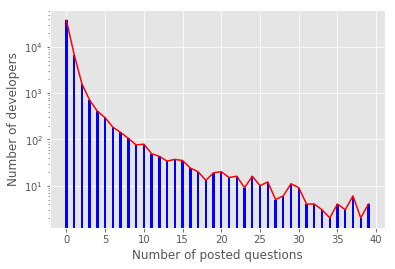

In [46]:
rq1_agg_req = requests.get("https://na2dey56vh.execute-api.us-east-1.amazonaws.com/dev/rq1_agg")
data = rq1_agg_req.json()['data']

df = pd.DataFrame(list(data))
df = df[df['_id']<40] # to show a similar plot

plt.bar(df['_id'], df.usersCount, log=True, color="blue", width=0.3)
plt.plot(df['_id'], df.usersCount, color="red")

plt.xlabel("Number of posted questions")
plt.ylabel("Number of developers")

plt.show()

#### Map-Reduce

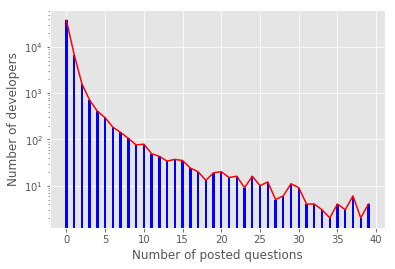

In [47]:
rq1_mapred_req = requests.get("https://na2dey56vh.execute-api.us-east-1.amazonaws.com/dev/rq1_mapred")
data = rq1_mapred_req.json()['data']

df = pd.DataFrame(list(data))

df = pd.concat([df.drop('value', axis=1), pd.DataFrame(df['value'].tolist())], axis=1)

df = df.groupby([0]).count().head(n=40)

plt.bar(df.index, df['_id'], log=True, color="blue", width=0.3)
plt.plot(df.index, df['_id'], color="red")

plt.xlabel("Number of posted questions")
plt.ylabel("Number of developers")

plt.show()

### RQ2
#### Framework de agregación

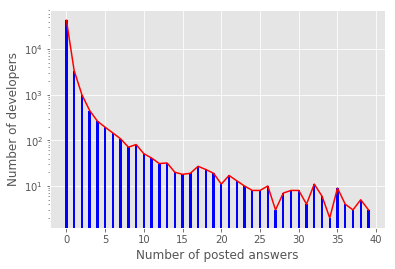

In [54]:
rq2_agg_req = requests.get("https://na2dey56vh.execute-api.us-east-1.amazonaws.com/dev/rq2_agg")
data = rq2_agg_req.json()['data']

df = pd.DataFrame(data)
df = df[df['_id']<40] # to show a similar plot

plt.bar(df['_id'], df.usersCount, log=True, color="blue", width=0.3)
plt.plot(df['_id'], df.usersCount, color="red")

plt.xlabel("Number of posted answers")
plt.ylabel("Number of developers")

plt.show()

#### Map-Reduce

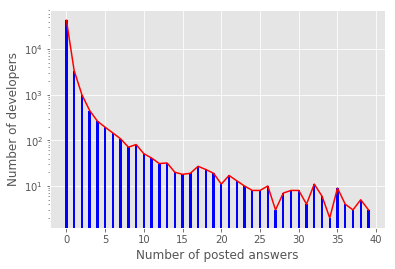

In [55]:
rq2_mapred_req = requests.get("https://na2dey56vh.execute-api.us-east-1.amazonaws.com/dev/rq2_mapred")
data = rq2_mapred_req.json()['data']

df = pd.DataFrame(data)

df = pd.concat([df.drop('value', axis=1), pd.DataFrame(df['value'].tolist())], axis=1)

df = df.groupby([0]).count().head(n=40)

plt.bar(df.index, df['_id'], log=True, color="blue", width=0.3)
plt.plot(df.index, df['_id'], color="red")

plt.xlabel("Number of posted answers")
plt.ylabel("Number of developers")

plt.show()

### RQ3
#### Framework de agregación

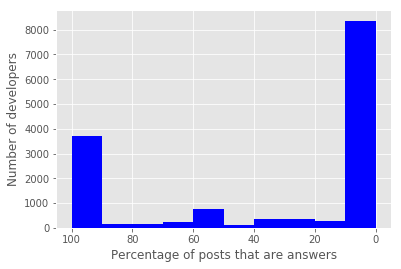

In [67]:
rq3_agg_req = requests.get("https://na2dey56vh.execute-api.us-east-1.amazonaws.com/dev/rq3_agg")
data = rq3_agg_req.json()['data']

df = pd.DataFrame(data)
df['total'] = df.ansCount+df.postsCount
df['ansRate'] = df.ansCount/df.total*100

df_dropna = df.dropna()

plt.hist(df_dropna.ansRate, color = 'blue')
plt.gca().invert_xaxis()

plt.xlabel("Percentage of posts that are answers")
plt.ylabel("Number of developers")

plt.show()

#### Map-Reduce

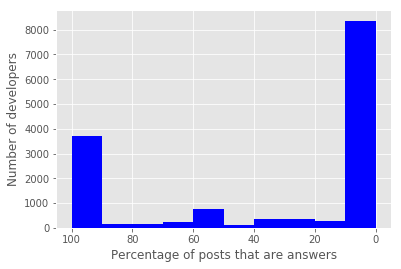

In [57]:
rq3_mapred_req = requests.get("https://na2dey56vh.execute-api.us-east-1.amazonaws.com/dev/rq3_mapred")
data = rq3_mapred_req.json()['data']

df = pd.DataFrame(data)
df = pd.concat([df.drop('value', axis=1), pd.DataFrame(df['value'].tolist())], axis=1)

df['total'] = df.answers+df.questions
df['ansRate'] = df.answers/df.total*100

df_dropna = df.dropna()

plt.hist(df_dropna.ansRate, color = 'blue')
plt.gca().invert_xaxis()

plt.xlabel("Percentage of posts that are answers")
plt.ylabel("Number of developers")

plt.show()

### RQ4
#### Framework de agregación

In [56]:
rq4_agg_req = requests.get("https://na2dey56vh.execute-api.us-east-1.amazonaws.com/dev/rq4_agg")
data = rq4_agg_req.json()['data']
data

[{'_id': {'min': 44942, 'max': 44946},
  'answers': [{'0q': 44946, '1a': 44942}, {'0q': 44942, '1a': 44946}],
  'nanswers': 2},
 {'_id': {'min': 463, 'max': 19600},
  'answers': [{'0q': 463, '1a': 19600}, {'0q': 19600, '1a': 463}],
  'nanswers': 2},
 {'_id': {'min': 2509, 'max': ''},
  'answers': [{'0q': 2509, '1a': ''}, {'0q': '', '1a': 2509}],
  'nanswers': 2},
 {'_id': {'min': 3275, 'max': 35873},
  'answers': [{'0q': 3275, '1a': 35873}, {'0q': 35873, '1a': 3275}],
  'nanswers': 2},
 {'_id': {'min': 227, 'max': 2004},
  'answers': [{'0q': 2004, '1a': 227}, {'0q': 227, '1a': 2004}],
  'nanswers': 2},
 {'_id': {'min': 18376, 'max': 26302},
  'answers': [{'0q': 18376, '1a': 26302}, {'0q': 26302, '1a': 18376}],
  'nanswers': 2},
 {'_id': {'min': 250, 'max': 9897},
  'answers': [{'0q': 250, '1a': 9897}, {'0q': 9897, '1a': 250}],
  'nanswers': 2},
 {'_id': {'min': 250, 'max': 2429},
  'answers': [{'0q': 250, '1a': 2429}, {'0q': 2429, '1a': 250}],
  'nanswers': 2},
 {'_id': {'min': 250, 'm

## Replicación de las consultas de la sesión 2 desde el notebook

In [34]:
client = MongoClient("ec2-3-82-61-111.compute-1.amazonaws.com",27017)
client

db = client.stackoverflow
db = client['stackoverflow']
db

Database(MongoClient(host=['ec2-3-82-61-111.compute-1.amazonaws.com:27017'], document_class=dict, tz_aware=False, connect=True), 'stackoverflow')

### RQ1
#### Framework de agregación

In [69]:
def rq1_agg ():
    dataRQ1 = db.users.aggregate( [
            {'$lookup': {
                'from': 'posts',
                'localField' : 'Id',
                'foreignField' : 'OwnerUserId',
                'as': 'posts'}
            },
            {'$project' : {
                'Id' : True,
                'posts': {
                    '$filter' : {
                       'input' : '$posts',
                       'as' : 'post',
                       'cond' : { '$eq': ['$$post.PostTypeId', 1] }
                }}
            }},
            {'$project' : {
                'Id' : True,
                'postsCount': { '$size' : '$posts'}
            }},
            {'$group' : {
                '_id' : '$postsCount',
                'usersCount': { '$sum' : 1 }
            }},
            {'$sort' :  { '_id' : -1 } }
    ])
    data = list(dataRQ1)
    return data

#### Map-Reduce

In [70]:
def rq1_mapred ():
    rq1_map = Code("""
    function () {
        if (this.PostTypeId == 1) {
            emit(this.OwnerUserId, 1);
        }
    }
    """)

    rq1_reduce = Code(
    '''
    function (key, values)
    {
        return Array.sum(values);
    }
    ''')

    db.posts.map_reduce(rq1_map, rq1_reduce, out='rq1')

    rq1_map2 = Code("""
    function () {
        emit(this.Id, 0);
    }
    """)

    rq1_reduce2 = Code("""
    function (key, values) {
        return Array.sum(values);
    }
    """)

    db.users.map_reduce(rq1_map2, rq1_reduce2, out={'reduce' : 'rq1'})

    data = list(db.rq1.find())
    return data

### RQ2
#### Framework de agregación

In [82]:
def rq2_agg():    
    dataRQ2 = db.users.aggregate( [
            {'$lookup': {
                'from': 'posts',
                'localField' : 'Id',
                'foreignField' : 'OwnerUserId',
                'as': 'posts'}
            },
            {'$project' : {
                'Id' : True,
                'answers': {
                    '$filter' : {
                       'input' : '$posts',
                       'as' : 'post',
                       'cond' : { '$eq': ['$$post.PostTypeId', 2] }
                }}
            }},
            {'$project' : {
                'Id' : True,
                'ansCount': { '$size' : '$answers'}
            }},
            {'$group' : {
                '_id' : '$ansCount',
                'usersCount': { '$sum' : 1 }
            }},
            {'$sort' :  { '_id' : -1 } }
    ])
    data = list(dataRQ2)
    return data

#### Map-Reduce

In [83]:
def rq2_mapred():
    rq2_map = Code("""
    function () {
        if (this.PostTypeId == 2) {
            emit(this.OwnerUserId, 1);
        }
    }
    """)

    rq2_reduce = Code(
    '''
    function (key, values)
    {
        return Array.sum(values);
    }
    ''')

    db.posts.map_reduce(rq2_map, rq2_reduce, out='rq2')

    rq2_map2 = Code("""
    function () {
        emit(this.Id, 0);
    }
    """)

    rq2_reduce2 = Code("""
    function (key, values) {
        return Array.sum(values);
    }
    """)

    db.users.map_reduce(rq2_map2, rq2_reduce2, out={'reduce' : 'rq2'})

    rq2MR = db.rq2.find()
    data = list(rq2MR)
    return data

### RQ3
#### Framework de agregación

In [84]:
def rq3_agg():
    dataRQ3 = db.users.aggregate( [
            {'$lookup': {
                'from': 'posts',
                'localField' : 'Id',
                'foreignField' : 'OwnerUserId',
                'as': 'posts'}
            },
            {'$project' : {
                'Id' : True,
                'posts': {
                    '$filter' : {
                       'input' : '$posts',
                       'as' : 'post',
                       'cond' : { '$eq': ['$$post.PostTypeId', 1] }
                }},
                'answers': {
                    '$filter' : {
                       'input' : '$posts',
                       'as' : 'post',
                       'cond' : { '$eq': ['$$post.PostTypeId', 2] }
                }}
            }},
            {'$project' : {
                'postsCount': { '$size' : '$posts'},
                'ansCount': { '$size' : '$answers'}

            }}
    ])
    data = list(dataRQ3)
    return data

#### Map-Reduce

In [85]:
def rq3_mapred():
    rq3_map = Code("""
    function () {
        object = {
            questions: 0,
            answers: 0
        };    
        if (this.PostTypeId == 2) {
            object.answers = 1;
            object.questions = 0;
        } else if (this.PostTypeId == 1) {
            object.questions = 1;
            object.answers = 0;
        }
        emit(this.OwnerUserId, object);
    }
    """)

    rq3_reduce = Code(
    '''
    function (key, values)
    {
        questions = 0;
        answers = 0;
        for(i = 0; i<values.length; i++) {
            questions += values[i].questions;
            answers += values[i].answers;
        }
        return {questions, answers};
    }
    ''')

    db.posts.map_reduce(rq3_map, rq3_reduce, out='rq3')

    rq3_map2 = Code("""
    function () {
        object = {
            questions: 0,
            answers: 0
        };
        emit(this.Id, object);
    }
    """)

    rq3_reduce2 = Code("""
    function (key, values)
    {
        questions = 0;
        answers = 0;
        for(i = 0; i<values.length; i++) {
            questions += values[i].questions;
            answers += values[i].answers;
        }
        return {questions, answers};
    }
    """)

    db.users.map_reduce(rq3_map2, rq3_reduce2, out={'reduce' : 'rq3'})
    data = list(db.rq3.find())
    return data

### RQ4
#### Framework de agregación

In [93]:
def rq4_agg():
    RQ4 = db.posts.aggregate( [
            {'$match': { 'AcceptedAnswerId' : {'$ne': ''}}},
            {'$lookup': {
                'from': "posts", 
                'localField': "AcceptedAnswerId",
                'foreignField': "Id",
                'as': "answer"}
            },
            { 
                '$unwind' : '$answer'
            },
            {
                '$project' : { 'OwnerUserId': True, 
                               'answerer' : '$answer.OwnerUserId'
                             }
            },
            {
                '$group' : {'_id' : {'min' : { '$min' : ['$OwnerUserId' , '$answerer'] },
                                     'max' : { '$max' : ['$OwnerUserId' , '$answerer'] }},
                            'answers' : {'$addToSet' : { '0q':'$OwnerUserId', '1a': '$answerer'}}
                            }
            },
            {
                '$project': {
                    'answers' : True,
                    'nanswers' : { '$size' : '$answers'}
                }
            },
            {
                '$match' : { 'nanswers' : { '$eq' : 2}}
            }
        ])
    data = list(RQ4)
    return data

## Comparativa entre la ejecución del código en AWS Lambda frente al notebook

In [112]:
queries = ["rq1_agg", "rq1_mapred", "rq2_agg", "rq2_mapred", "rq3_agg", "rq3_mapred", "rq4_agg"]

awstime = []
awsquerytime = []
localtime = []

for q in queries:
    
    start_time = timeit.default_timer()
    req_body = requests.get("https://na2dey56vh.execute-api.us-east-1.amazonaws.com/dev/{}".format(q)).json()
    awsreqtime = timeit.default_timer() - start_time
    awsquerytime.append(awsreqtime)
    
    awstime.append(req_body['elapsedTime'])
    
    start_time = timeit.default_timer()
    locals()[q]()
    loctime = timeit.default_timer() - start_time
    localtime.append(loctime)
    
d = {'awstime': awstime, 'awsquerytime': awsquerytime, "localtime": localtime}
df = pd.DataFrame(d)
df.index = queries
df

,awstime,awsquerytime,localtime
rq1_agg,3.634432,4.185701,3.746500
rq1_mapred,5.327854,8.525230,8.373794
rq2_agg,3.503671,3.943997,3.733081
rq2_mapred,5.011377,8.576768,6.940919
rq3_agg,4.657880,10.310754,17.392957
rq3_mapred,7.457691,13.132879,10.364341
rq4_agg,1.200995,1.749872,1.302709


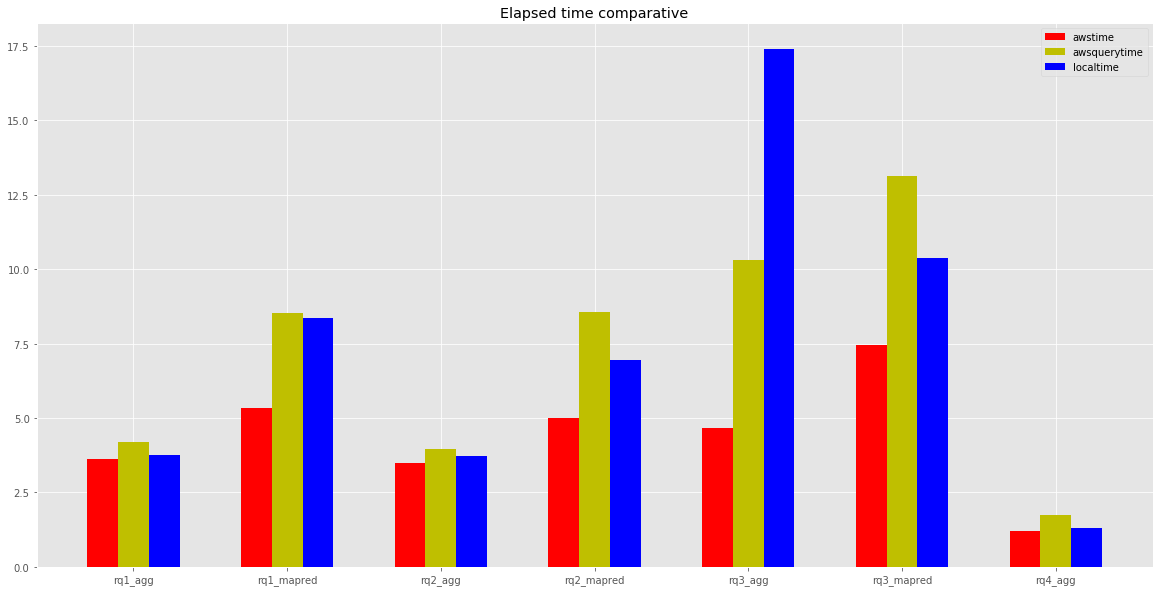

In [113]:
N = df.shape[0]

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)

ind = np.arange(N)    # the x locations for the groups
width = 0.2         # the width of the bars

p1 = ax.bar(ind, df['awstime'], width, color='r', bottom=0)
p2 = ax.bar(ind + width, df['awsquerytime'], width, color='y', bottom=0)
p3 = ax.bar(ind + 2*width, df['localtime'], width, color='b', bottom=0)

ax.set_title('Elapsed time comparative')
ax.set_xticks(ind + 2*width / 2)
ax.set_xticklabels(queries)

ax.legend((p1[0], p2[0], p3[0]), ('awstime', 'awsquerytime', 'localtime'))

plt.show()